### Project: Face Mask Detection, Classification, and Segmentation
Total Marks: 15 Marks\
Deadline: 24th March\
Objective:
Develop a computer vision solution to classify and segment face masks in images. The
project involves using handcrafted features with machine learning classifiers and deep
learning techniques to perform classification and segmentation.


Dataset:
* A labeled dataset containing images of people with and without face masks can be
accessed here: https://github.com/chandrikadeb7/Face-Mask-
Detection/tree/master/dataset

* A Masked Face Segmentation Dataset with ground truth face masks can be accessed
here: https://github.com/sadjadrz/MFSD

### Tasks
1.  Binary Classification Using Handcrafted Features and ML Classifiers (4 Marks)
  1. Extract handcrafted features from the dataset.
  2. Train and evaluate at least two machine learning classifiers (e.g., SVM, Neural
network) to classify faces as "with mask" or "without mask."
  3. Report and compare the accuracy of the classifiers.
2. Binary Classification Using CNN (3 Marks)
  1. Design and train a Convolutional Neural Network (CNN) to perform binary
classification on the same dataset.
  2. Try a few hyper-parameter variations (e.g., learning rate, batch size, optimizer,
activation function in the classification layer) and report the results.
  3. Compare the CNN's performance with the ML classifiers.
3. Region Segmentation Using Traditional Techniques (3 Marks)
  1. Implement a region-based segmentation method (e.g., thresholding, edge
detection) to segment the mask regions for faces identified as "with mask."
  2. Visualize and evaluate the segmentation results.
4. Mask Segmentation Using U-Net (5 Marks)
  1. Train a U-Net model for precise segmentation of mask regions in the images.
  2. Compare the performance of U-Net with the traditional segmentation method
using metrics like IoU or Dice score.




In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.models import Model



from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm


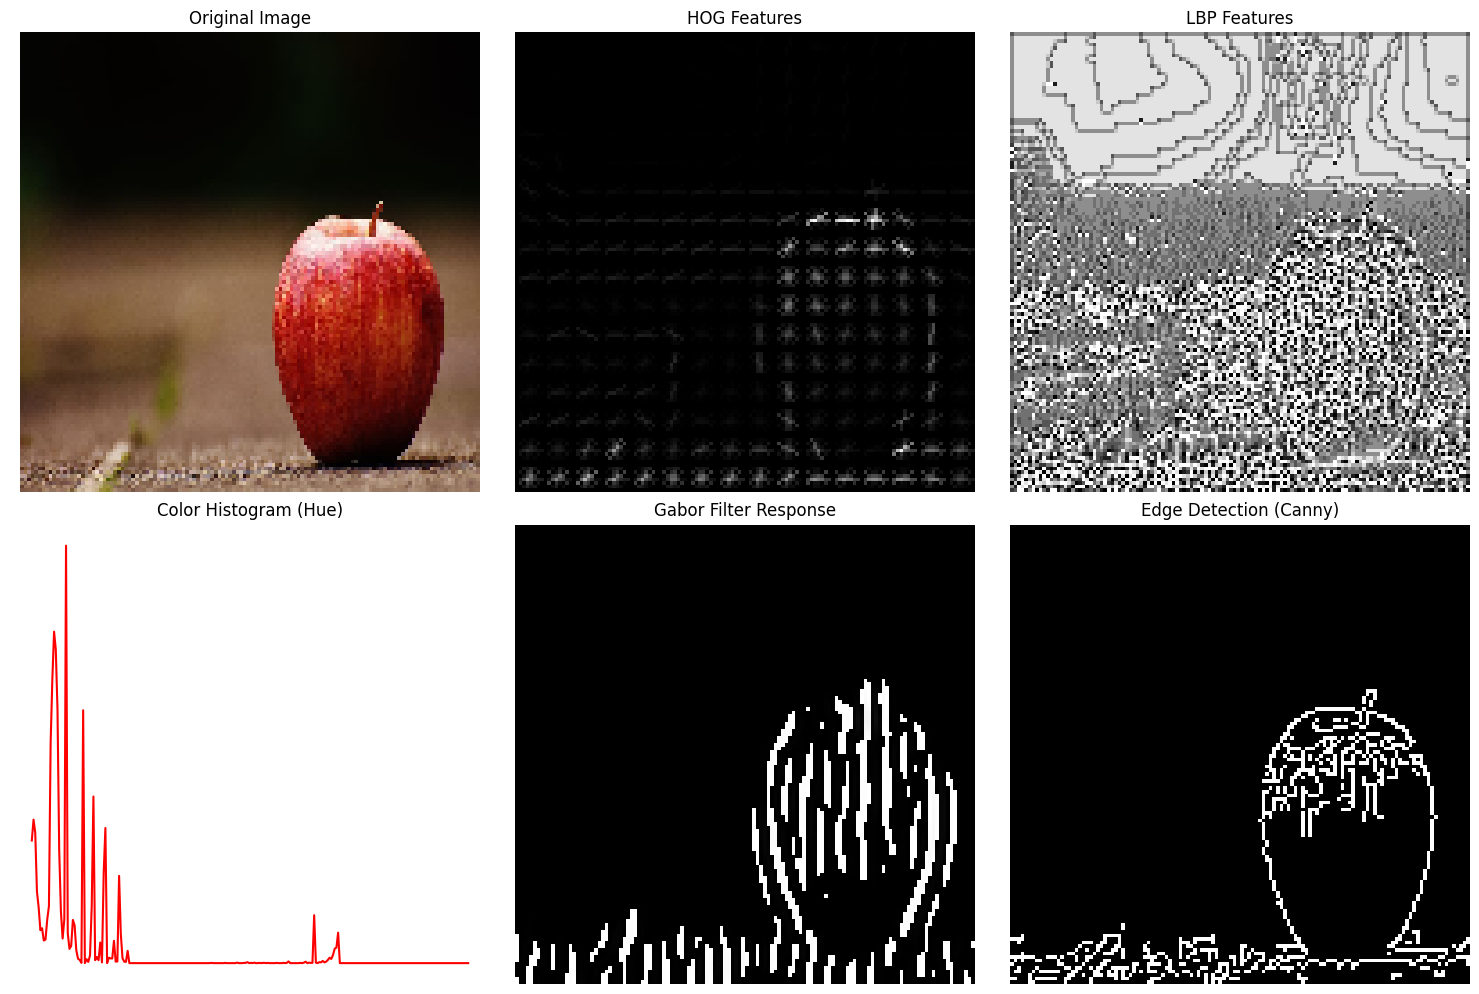

In [1]:
# Load an example image
image_path = "apple.jpg"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.resize(image, (128, 128))  # Resize for consistency
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### 1. HOG Feature Extraction ###
hog_features, hog_image = hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                              visualize=True, block_norm='L2-Hys')

### 2. Local Binary Pattern (LBP) ###
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

### 3. Color Histogram (HSV) ###
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])  # Hue channel histogram

### 4. Gabor Filter ###
gabor_kernel = gabor(gray, frequency=0.2)[0]  # Gabor filter at frequency 0.2

### 5. Edge Detection (Canny) ###
edges = cv2.Canny(gray, 100, 200)

# Display the features
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title("Original Image")

axs[0, 1].imshow(hog_image, cmap="gray")
axs[0, 1].set_title("HOG Features")

axs[0, 2].imshow(lbp, cmap="gray")
axs[0, 2].set_title("LBP Features")

axs[1, 0].plot(hist_hue, color="red")
axs[1, 0].set_title("Color Histogram (Hue)")

axs[1, 1].imshow(gabor_kernel, cmap="gray")
axs[1, 1].set_title("Gabor Filter Response")

axs[1, 2].imshow(edges, cmap="gray")
axs[1, 2].set_title("Edge Detection (Canny)")

for ax in axs.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [2]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4590, done.
remote: Total 4590 (delta 0), reused 0 (delta 0), pack-reused 4590 (from 1)
Receiving objects: 100% (4590/4590), 186.72 MiB | 30.69 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Updating files: 100% (4155/4155), done.


In [5]:
print("Face Mask Classification Dataset:")
os.listdir("Face-Mask-Detection/dataset")

Face Mask Classification Dataset:


['with_mask', 'without_mask']

1. Histogram of Oriented Gradients (HOG)
Why?

HOG captures edge and shape information, which is useful for detecting objects like faces and masks.
It is robust to changes in lighting and small variations in pose.
Used in pedestrian detection and face recognition.

Supporting Research:

Dalal & Triggs (2005) – "Histograms of Oriented Gradients for Human Detection" (CVPR)

This seminal paper introduced HOG and showed its effectiveness in detecting objects in images, making it a strong candidate for face mask detection.

J. R. Uijlings et al. (2013) – "Selective Search for Object Recognition" (IJCV)

Demonstrates HOG's effectiveness in object localization and recognition.

2. Local Binary Patterns (LBP)
Why?

LBP captures micro-texture variations, useful for distinguishing masks from facial skin.
Computationally efficient and invariant to illumination changes.
Frequently used in face recognition systems.
Supporting Research:

T. Ahonen et al. (2006) – "Face Recognition with Local Binary Patterns" (TPAMI)

Showed LBP’s efficiency in capturing face texture details.
Link
R. O. Duda, P. E. Hart, and D. G. Stork (2001) – "Pattern Classification"

Classic textbook that discusses LBP in texture-based classification tasks.
3. Color Histograms
Why?

Masks usually have distinct color patterns (blue, white, black) compared to skin tones.
Provides additional discriminatory power for classifying "with mask" vs. "without mask."
Supporting Research:

Swain & Ballard (1991) – "Color Indexing" (IJCV)

Demonstrated that color histograms are effective for object recognition.
Link
G. Pass et al. (1996) – "Comparing Images Using Color Coherence Vectors" (ACM Multimedia)

Extends color histogram features for image classification tasks.
4. Gabor Filters
Why?

Gabor filters are used to extract multi-scale texture information.
They mimic the behavior of the human visual system for edge detection.
Helps differentiate between mask and non-mask areas due to texture differences.
Supporting Research:

M. J. Jones & T. Poggio (1998) – "Multidimensional Morphable Models"

Used Gabor features for face recognition.
Link
D. Gabor (1946) – "Theory of Communication"

Introduced Gabor filters, which later became a standard feature in texture analysis.

5. Scale-Invariant Feature Transform (SIFT)
Why?

Extracts distinctive keypoints that are invariant to scale, rotation, and lighting.
Useful for detecting important regions in an image, such as the nose and mouth area, which might be occluded by masks.
Supporting Research:

David G. Lowe (2004) – "Distinctive Image Features from Scale-Invariant Keypoints" (IJCV)
One of the most cited papers in computer vision, demonstrating SIFT’s effectiveness.


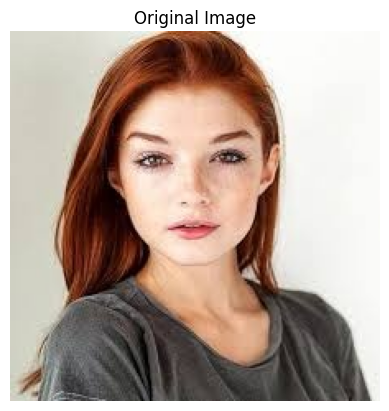

In [9]:
# Load image
image_path = "/content/Face-Mask-Detection/dataset/without_mask/175.jpg"
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.show()


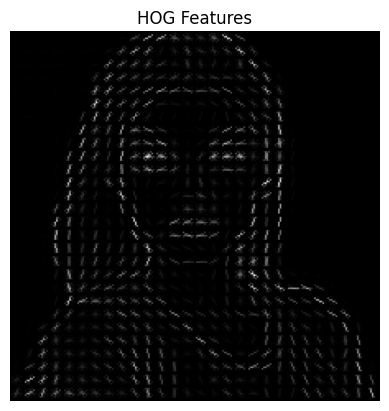

In [10]:
# Compute HOG features and visualization
hog_features, hog_image = hog(image_gray, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

# Display HOG Image
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Features")
plt.axis("off")
plt.show()


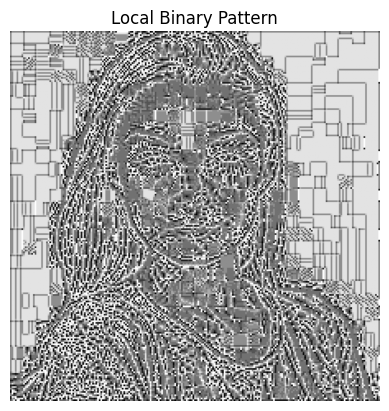

In [11]:
#local binary patterns

radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(image_gray, n_points, radius, method="uniform")

# Display LBP Image
plt.imshow(lbp, cmap="gray")
plt.title("Local Binary Pattern")
plt.axis("off")
plt.show()


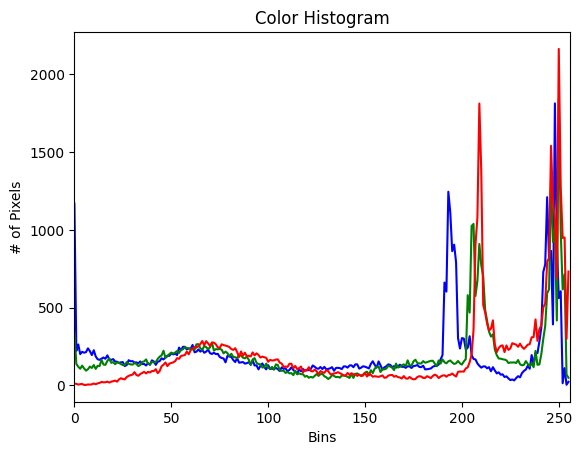

In [12]:
#color histogram
def plot_color_histogram(image):
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    plt.figure()
    plt.title("Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")

    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])

        plt.plot(hist, color=color)
        plt.xlim([0, 256])

    plt.show()

plot_color_histogram(image)


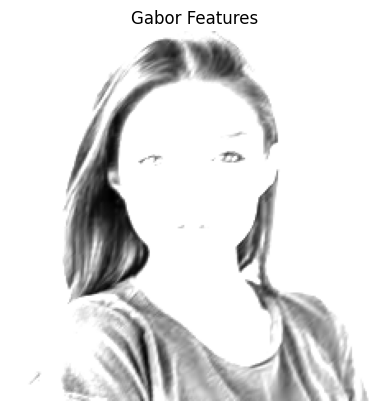

In [13]:
#gabor features
def gabor_feature_extraction(img, ksize=3, sigma=0.5, theta=np.pi/4, lambd=10.0, gamma=0.5):
    g_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    filtered = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
    return filtered

gabor_filtered = gabor_feature_extraction(image_gray)

# Display Gabor Feature Map
plt.imshow(gabor_filtered, cmap="gray")
plt.title("Gabor Features")
plt.axis("off")
plt.show()


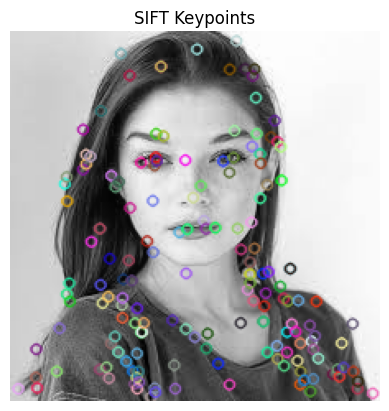

In [14]:
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image_gray, None)
image_sift = cv2.drawKeypoints(image_gray, keypoints, None)

# Display SIFT Keypoints
plt.imshow(image_sift, cmap="gray")
plt.title("SIFT Keypoints")
plt.axis("off")
plt.show()


## TASK A: ML Models on Handcrafted Features

In [ ]:
FEATURES_DIR = "/content/features"  # Directory to save features

if not os.path.exists(FEATURES_DIR):
    os.makedirs(FEATURES_DIR)

# Load dataset and extract features for each method
def load_data(feature_extractor, use_sift=False):
    feature_name = feature_extractor.__name__
    feature_file = os.path.join(FEATURES_DIR, f"{feature_name}_features.pkl")

    # If saved features exist, load them
    if os.path.exists(feature_file):
        print(f"Loading saved features for {feature_name}...")
        with open(feature_file, "rb") as f:
            X, y = pickle.load(f)
        return np.array(X), np.array(y)

    X, y = [], []
    sift = cv2.SIFT_create() if use_sift else None
    all_descriptors = []

    for label, path in enumerate([MASKED_PATH, UNMASKED_PATH]):
        for img_name in tqdm(os.listdir(path), desc=f"Extracting {feature_name}"):
            img_path = os.path.join(path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, (128, 128))

            if use_sift:
                descriptors = extract_sift_features(image, sift)
                if descriptors is not None:
                    all_descriptors.append(descriptors)
            else:
                features = feature_extractor(image)
                X.append(features)
                y.append(label)

    if use_sift:
        all_descriptors = np.vstack(all_descriptors)
        kmeans = KMeans(n_clusters=128, random_state=42, n_init=10)
        kmeans.fit(all_descriptors)

        for label, path in enumerate([MASKED_PATH, UNMASKED_PATH]):
            for img_name in tqdm(os.listdir(path), desc="Extracting BoW for SIFT"):
                img_path = os.path.join(path, img_name)
                image = cv2.imread(img_path)
                if image is None:
                    continue
                image = cv2.resize(image, (128, 128))
                features = extract_sift_features(image, sift, kmeans)
                X.append(features)
                y.append(label)

    # Save extracted features
    with open(feature_file, "wb") as f:
        pickle.dump((X, y), f)
    print(f"Saved features for {feature_name} to {feature_file}")
    # print(np.array(X).shape, np.array(y).shape)
    return np.array(X), np.array(y)


In [ ]:
# Dataset paths (update these based on your dataset)
MASKED_PATH = "/content/Face-Mask-Detection/dataset/with_mask"
UNMASKED_PATH = "/content/Face-Mask-Detection/dataset/without_mask"

# Function to extract individual features
def extract_hog(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')

def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
    return lbp_hist  # LBP Histogram

def extract_color_hist(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [16], [0, 256]).flatten()
    return hist_hue / hist_hue.sum()  # Normalize

def extract_gabor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gabor_kernel = gabor(gray, frequency=0.2)[0]
    return np.array([gabor_kernel.mean(), gabor_kernel.var()])

def extract_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return np.histogram(edges.ravel(), bins=16, range=(0, 256), density=True)[0]

def extract_sift_features(image, sift, kmeans=None):
    """ Extracts SIFT keypoints and returns BoW representation if kmeans is provided """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    if des is None:
        return np.zeros((128,))  # Return zero vector if no keypoints are detected
    if kmeans is not None:
        labels = kmeans.predict(des)
        bow_vector = np.histogram(labels, bins=np.arange(0, kmeans.n_clusters+1), density=True)[0]
        return bow_vector
    return des  # Return descriptors for clustering phase



# Train and evaluate SVM for a given feature
def train_and_evaluate(feature_extractor, use_sift=False):
    print(f"\nTraining SVM with {feature_extractor.__name__}...")
    X, y = load_data(feature_extractor, use_sift=use_sift)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train SVM
    svm_model = SVC(kernel="linear")
    svm_model.fit(X_train, y_train)

    # Predict
    y_pred = svm_model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"{feature_extractor.__name__} Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Confusion Matrix:\n", cm)

# Run classification with different features
train_and_evaluate(extract_hog)         # HOG
train_and_evaluate(extract_lbp)         # LBP
train_and_evaluate(extract_color_hist)  # Color Histogram
train_and_evaluate(extract_gabor)       # Gabor
train_and_evaluate(extract_edges)       # Canny Edge
train_and_evaluate(extract_sift_features, use_sift=True)  # SIFT



Training SVM with extract_hog...


Extracting extract_hog: 100%|██████████| 1930/1930 [00:17<00:00, 111.00it/s]


Saved features for extract_hog to /content/features/extract_hog_features.pkl
extract_hog Accuracy: 88.52%
Precision: 0.85
Recall: 0.91
Confusion Matrix:
 [[393  60]
 [ 34 332]]

Training SVM with extract_lbp...


Extracting extract_lbp: 100%|██████████| 1930/1930 [00:08<00:00, 232.18it/s]


Saved features for extract_lbp to /content/features/extract_lbp_features.pkl
extract_lbp Accuracy: 73.75%
Precision: 0.73
Recall: 0.65
Confusion Matrix:
 [[366  87]
 [128 238]]

Training SVM with extract_color_hist...


Extracting extract_color_hist: 100%|██████████| 1930/1930 [00:01<00:00, 1467.44it/s]


Saved features for extract_color_hist to /content/features/extract_color_hist_features.pkl
extract_color_hist Accuracy: 73.50%
Precision: 0.65
Recall: 0.87
Confusion Matrix:
 [[285 168]
 [ 49 317]]

Training SVM with extract_gabor...


Extracting extract_gabor: 100%|██████████| 1930/1930 [00:46<00:00, 41.95it/s]


Saved features for extract_gabor to /content/features/extract_gabor_features.pkl
extract_gabor Accuracy: 61.05%
Precision: 0.56
Recall: 0.59
Confusion Matrix:
 [[284 169]
 [150 216]]

Training SVM with extract_edges...


Extracting extract_edges: 100%|██████████| 1930/1930 [00:02<00:00, 645.58it/s]


Saved features for extract_edges to /content/features/extract_edges_features.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


extract_edges Accuracy: 55.31%
Precision: 0.00
Recall: 0.00
Confusion Matrix:
 [[453   0]
 [366   0]]

Training SVM with extract_sift_features...


Extracting extract_sift_features: 100%|██████████| 1930/1930 [00:16<00:00, 117.20it/s]


KeyboardInterrupt: 

In [24]:
# combine the features into a vector data

COMBINED_FEATURES_FILE = os.path.join("/content/combined_features.pkl")

def load_saved_features():
    feature_files = [
        "extract_hog_features.pkl",
        "extract_lbp_features.pkl",
        "extract_color_hist_features.pkl",
        "extract_gabor_features.pkl",
        "extract_edges_features.pkl",
        "extract_sift_features.pkl"
    ]

    loaded_features = []
    y_labels = None

    for file in feature_files:
        feature_path = os.path.join(FEATURES_DIR, file)
        if os.path.exists(feature_path):
            print(f"Loading {file}...")
            with open(feature_path, "rb") as f:
                X, y = pickle.load(f)
                loaded_features.append(X)

                # Ensure labels are the same across all features
                if y_labels is None:
                    y_labels = y
                elif not np.array_equal(y_labels, y):
                    raise ValueError(f"Mismatch in labels for {file}")

    # Stack all feature vectors horizontally
    X_combined = np.hstack(loaded_features)

    # Save the final feature vector
    with open(COMBINED_FEATURES_FILE, "wb") as f:
        pickle.dump((X_combined, y_labels), f)
    print(f"Saved combined features to {COMBINED_FEATURES_FILE}")

    return X_combined, y_labels


Loading extract_hog_features.pkl...
Loading extract_lbp_features.pkl...
Loading extract_color_hist_features.pkl...
Loading extract_gabor_features.pkl...
Loading extract_edges_features.pkl...
Saved combined features to /content/features/combined_features.pkl
(4095, 8144)
New shape after PCA: (4095, 50)

Training Random Forest...
Random Forest Accuracy: 89.13%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       453
           1       0.89      0.87      0.88       366

    accuracy                           0.89       819
   macro avg       0.89      0.89      0.89       819
weighted avg       0.89      0.89      0.89       819



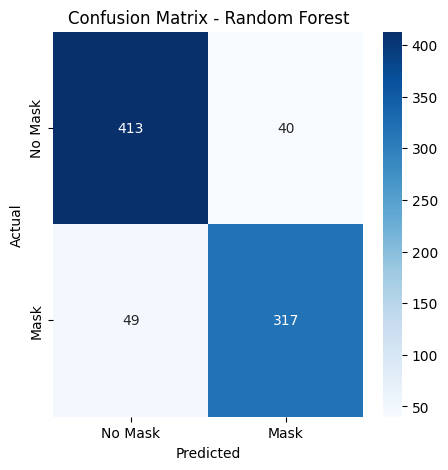


Training Naive Bayes...
Naive Bayes Accuracy: 81.81%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       453
           1       0.79      0.81      0.80       366

    accuracy                           0.82       819
   macro avg       0.82      0.82      0.82       819
weighted avg       0.82      0.82      0.82       819



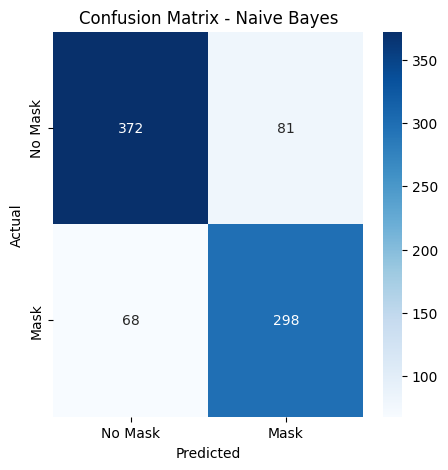

In [ ]:
def train_and_evaluate_models():
    # Load the combined feature vectors
    X, y = load_saved_features()
    print(X.shape)
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=50)
    reduced_features = pca.fit_transform(X)

    print("New shape after PCA:", reduced_features.shape)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(reduced_features, y, test_size=0.2, random_state=42)

    # Define ML models to train
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Naive Bayes": GaussianNB()
    }

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate model
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"{model_name} Accuracy: {acc * 100:.2f}%")
        print(f"Classification Report:\n{report}")

        # Plot confusion matrix
        plt.figure(figsize=(5, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

# Run the training and evaluation
train_and_evaluate_models()


## TASK B: Train and tune CNN on same data

In [21]:
# Path to the folder containing images
MASKED_PATH = "/content/Face-Mask-Detection/dataset/with_mask"
UNMASKED_PATH = "/content/Face-Mask-Detection/dataset/without_mask"
image_folder = "/content/Face-Mask-Detection/dataset/without_mask"

widths, heights = [], []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)  # Read image
    if img is not None:
        h, w = img.shape[:2]  # Get height and width
        widths.append(w)
        heights.append(h)

# Compute statistics
avg_width, avg_height = np.mean(widths), np.mean(heights)
min_width, min_height = np.min(widths), np.min(heights)
max_width, max_height = np.max(widths), np.max(heights)

# Display results
print(f"Average Image Size: {avg_width:.2f} x {avg_height:.2f}")
print(f"Min Image Size: {min_width} x {min_height}")
print(f"Max Image Size: {max_width} x {max_height}")



Average Image Size: 212.00 x 226.15
Min Image Size: 95 x 88
Max Image Size: 960 x 960


In [26]:
# Constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 100

# Load dataset and preprocess
def load_images():
    X, y = [], []
    for label, path in enumerate([MASKED_PATH, UNMASKED_PATH]):
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize
            X.append(image)
            y.append(label)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    return train_test_split(X, y, test_size=0.2, random_state=42)

# Load dataset
X_train, X_test, y_train, y_test = load_images()


In [27]:
def create_cnn(activation='relu', optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3,3), activation=activation, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation=activation),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation=activation),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation=activation),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [28]:
# Hyperparameter variations
variations = [
    ('relu', 'adam'),
    ('relu', 'sgd'),
    ('tanh', 'adam'),
    ('tanh', 'sgd')
]

for activation, optimizer in variations:
    print(f"\nTraining CNN with activation={activation}, optimizer={optimizer}")
    model = create_cnn(activation, optimizer)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=1)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy ({activation}, {optimizer}): {test_acc * 100:.2f}%")



Training CNN with activation=relu, optimizer=adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7411 - loss: 0.5341 - val_accuracy: 0.8962 - val_loss: 0.3024
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9091 - loss: 0.2410 - val_accuracy: 0.9084 - val_loss: 0.2229
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9240 - loss: 0.1894 - val_accuracy: 0.9280 - val_loss: 0.2093
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9416 - loss: 0.1515 - val_accuracy: 0.9524 - val_loss: 0.1339
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9580 - loss: 0.1161 - val_accuracy: 0.9451 - val_loss: 0.1630
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9580 - loss: 0.1184 - val_accuracy: 0.9512 - val_loss: 0.1589
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9677 - loss: 0.0833 - val_accuracy: 0.9548 - val_loss: 0.1720
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9682 - loss: 0.0874 -

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
CNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       453
         1.0       0.95      0.95      0.95       366

    accuracy                           0.96       819
   macro avg       0.96      0.96      0.96       819
weighted avg       0.96      0.96      0.96       819



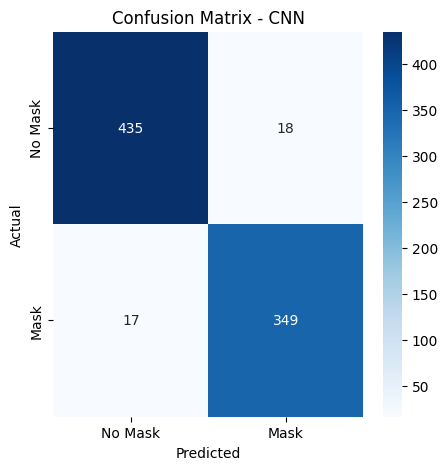

In [29]:
# Predict labels using CNN
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification Report
print("CNN Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN")
plt.show()


### Compare and write results HERE

In [35]:
def create_cnn_v2(activation='relu', optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3,3), activation=activation, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(256, (3,3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(256, activation=activation),
        Dropout(0.5),
        Dense(128, activation=activation),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [37]:
EPOCHS = 50
variations = [
    ('relu', 'adam'),
    ('relu', 'sgd'),
    ('tanh', 'adam'),
    ('tanh', 'sgd')
]

for activation, optimizer in variations:
    print(f"\nTraining CNN with activation={activation}, optimizer={optimizer}")
    model = create_cnn_v2(activation, optimizer)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=1)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy ({activation}, {optimizer}): {test_acc * 100:.2f}%")


Training CNN with activation=relu, optimizer=adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.7885 - loss: 1.2913 - val_accuracy: 0.4505 - val_loss: 4.2101
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8614 - loss: 0.7124 - val_accuracy: 0.5995 - val_loss: 0.9934
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8969 - loss: 0.4217 - val_accuracy: 0.6166 - val_loss: 1.6855
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9145 - loss: 0.2526 - val_accuracy: 0.8193 - val_loss: 0.4159
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9254 - loss: 0.2370 - val_accuracy: 0.8657 - val_loss: 0.3168
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9479 - loss: 0.1536 - val_accuracy: 0.9487 - val_loss: 0.1574
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9524 - loss: 0.1465 - val_accuracy: 0.9475 - val_loss: 0.1623
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9590 - loss: 0.1149 - val_ac